<table><tr><td><img src='hzz.png' width="570"></td><td><img src='ATLAS-figaux_01.png' width="800"></td></tr></table>

#  How much Higgs? - Intro
- **Overview**
    - Welcome to the tutorial that covers the first half of the Data Science in High Energy Physics module. The notebook is based on statistical analysis of open data and simulation from the ATLAS experiment at CERN.  Even if the physics context of this data is not entirely clear to you, it should not be a problem as understanding anything beyond the next paragraph is not neccessary.

- **The physics in a nutshell**
    - The Higgs boson was theorised in the 1960s as the fundamental particle that is responsible for giving mass to other fundamental particles. The problem is, the Higgs boson is extremely difficult to produce in lab conditions. Hence the Large Hadron Collider had to be built at CERN in order to provide enough high energy particle collisions to produce a significant Higgs bosons such that we could confirm the existence of this elusive boson. In 2012, the ATLAS and CMS experiments at the LHC announced that they had finally discovered the Higgs boson and the Nobel Prize in physics was subsequently awarded to Peter Higgs and Francois Englert for the boson's prediction. One of the easiest ways to find a Higgs boson in the ATLAS data is to look for collisions (often called 'events') containing 4 *leptons* which can be either electrons or muons. Muons are the slightly more massive cousin of the electron. This is because the Higgs boson can decay into two Z bosons, which in turn each decay into two leptons, leading to the four lepton signal. This process is depicted in the left hand diagram above where (reading left to right) two gluons collide to form a Higgs boson, which subsequently decays to two Z bosons and then four leptons. The right had image above shows a computerised illustration of **real** collision from the ATLAS data that contained four muons. In this notebook we will search through the ATLAS data for these events and compare what we find to predictions. 

- **Technical details**
    - The notebook contains code that performs a simple analysis of the data and simulation. All code is Python 3 and utilised quite a few python package which must be installed before running the notebook. All required packages are listed in the 'requirements.txt' file.  The code is interspersed with exercises where you are either asked to discuss the analysis in the previous cell and/or extend the existing analysis. Specifically, we will look at collisions contains 4 leptons (electrons or muons) and use a histogram of the masses of the 4 lepton system ($m_{llll}$) to play with some statistical ideas. In the last few excercises you are required to perform some analyses with less guidance.

- **Report**
    - You need to submit a 3-4 page report on this tutorial containg:
        - an introduction explaining, in your own words, the overall concept of the tutorial and the exercises therein. 
        - your solution for each exercise (including any plots you make or need to explain your answer)
            - code you developed to perform the last two exercises may be includes as an appendix to the 3-4 page report
        - a brief conclusion.

First we import some crucial python modules that will allow us to analyse the data.

In [20]:
import uproot3
import uproot3_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep
from scipy import stats

We need the following helper function to help use to calibrate the simualtion, we dont need to worry about what it actually does.

In [21]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

Here we are just defining the names of the files from where we will read the data and simulation. All data and MC samples should be downloaded to the local directory from https://vula.uct.ac.za/x/nF3H2b 
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/. The last file is the real collision data from ATLAS, the others are simulations of the physics processes we expect to have occured in the collisions. 

In [32]:
files = [
"mc_361106.Zee.4lep.root",
"mc_361107.Zmumu.4lep.root",
"mc_410000.ttbar_lep.4lep.root",
"mc_363490.llll.4lep.root",
"mc_363492.llvv.4lep.root",
"mc_363356.ZqqZll.4lep.root",    
"mc_345060.ggH125_ZZ4lep.4lep.root",
"mc_341964.WH125_ZZ4lep.4lep.root",
"mc_344235.VBFH125_ZZ4lep.4lep.root",
"mc_341947.ZH125_ZZ4lep.4lep.root",
"data.4lep.root"  
]

We need to select out the most interesting collisions from the data and simulation so that we can as clear as possible signal of Higgs boson production. The exact details of the cuts are not very important. In summary, we select collision in which four leptons (electrons or muons) have been detected. 

In [33]:
#------------DEFINING SOME VARIABLES AND OBJECTS FOR THE ANALYSIS----------------------------------------------------

lumi = 10#fb^-1
nBins = 34

minMass = 80
maxMass = 250

bins_ar = np.linspace(minMass, maxMass, num=(nBins+1))
mc_hist_list = []
sample_names = []

f = plt.figure()

H_125 = np.zeros([nBins])
H_bkg = np.zeros([nBins])

btagWP77 = 0.6459

#--------------------------------------------------------------------------------------------------------------------

for file in files: #looping over data and simulation files
    sample_name = file.split(".")[1] 
    sample_names.append(sample_name)
    tree = uproot3.open("Data/"+file)["mini"]

    mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, jet_MV2c10 = tree.arrays(["mcWeight", "SumWeights", "XSection","trigM", "trigE","scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON","scaleFactor_LepTRIGGER","lep_type","lep_pt", "lep_eta","lep_phi", "lep_E", "lep_charge", "lep_etcone20", "lep_ptcone30", "jet_n", "jet_pt", "jet_eta", "jet_phi","jet_E", "jet_MV2c10"], outputtype=tuple)
    print("File has been successfully opened!")
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    sum_lep_type = lep_type.sum()
    
    jetlv = LVepm.TLorentzVectorArray.from_ptetaphi(jet_pt, jet_eta, jet_phi, jet_E)
    jetlv = jetlv[jet_MV2c10.argsort()]    
    tags = jet_pt[jet_MV2c10 > btagWP77]

    trig_cut = ( (trigM==1) | (trigE==1))
    lep_kinematics_cut  = ( (lep_pt.max() > 20000) & (lep_pt.min() > 7000) & (lep_eta.min() >-2.5) & (lep_eta.max() < 2.5))
    lep_type_cut  = ((sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52))
    lep_iso_cut =  ((lep_reliso_pt.max() < 0.3) & (lep_reliso_pt.max() < 0.3))
    lept_count_cut = (leplv.counts ==4)
    lept_charge_cut = (lep_charge.sum()==0)
    
    # filtering events according to cuts above that select out interesting events
    event_cut = ( lep_kinematics_cut & lep_type_cut & lep_iso_cut  & lept_count_cut & lept_charge_cut)

    first_lep_p4 =  leplv[event_cut,0]
    second_lep_p4 = leplv[event_cut,1]
    third_lep_p4 =  leplv[event_cut,2]
    fourth_lep_p4 = leplv[event_cut,3]
    mcWeight = mcWeight[event_cut] 
    
    scaleFactor_PILEUP = scaleFactor_PILEUP[event_cut] 
    scaleFactor_ELE = scaleFactor_ELE[event_cut] 
    scaleFactor_MUON = scaleFactor_MUON[event_cut] 
    scaleFactor_LepTRIGGER = scaleFactor_LepTRIGGER[event_cut] 
    
    #construct 4-lepton system by adding 4-vectors of the leptons vectorially
    llll_p4 = first_lep_p4 + second_lep_p4 + third_lep_p4 + fourth_lep_p4  
    
    
    # make histograms of the m_llll distribution for simulation and data
    if(file.split("_")[0] == "mc"):
        finalWeight = get_xsec_weight(sample_name)*(mcWeight)*(scaleFactor_PILEUP)*(scaleFactor_ELE) *(scaleFactor_MUON)*(scaleFactor_LepTRIGGER)
        H, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)                        
        mc_hist_list.append(H)
        if("H125" in file):
            H_125 = np.add(H, H_125)
        else:
            #print("Sample Name = " + str(file) + " exp. num. events = " + str(np.sum(finalWeight)) )
            H_bkg = np.add(H, H_bkg)
    else:
        finalWeight = np.ones(len(mcWeight)) 
        sample_name = "Data (10 fb^-1)"
        H_data, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)

File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!


<Figure size 432x288 with 0 Axes>

With our events selected, we can compare our data with our expectations from theory. Our best theory of particle physics is known as the Standard Model, so the predictions here represent the expectations from the Standard Model after a simulation of how the ATLAS detector detects particles has been applied. 

Specifically, we plot a histogram of the number of collisions ("events") as a function of the mass of the four-lepton system. We use this mass because it distinguishes between the the Higgs signal, which has a peak at the higgs mass (125 GeV) and is zero elesehere, and the backgrounds which have a peak around 90 GeV and are flatter elsewhere.

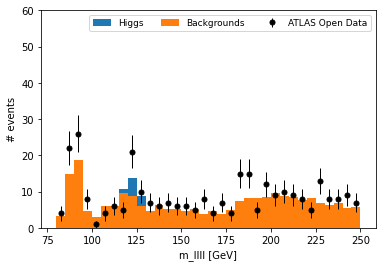

In [34]:
hep.histplot([H_bkg, H_125], bins=bins_ar, stack=True, label=["Backgrounds", "Higgs"], histtype='fill')
hep.histplot([H_data], bins=bins_ar, stack=False, yerr=True, histtype="errorbar", color="black",label="ATLAS Open Data")

plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("m_llll [GeV]")
plt.ylabel("# events")
plt.ylim([0.0, 60])
plt.show()

# Exercise 1 
 Discuss if the model(coloured histograms) by the is a good model for the data (black points) and why.
 Calculation of statistics to make your answer more quantitative is encouraged.

You first must define a chi-squared function that will quantify how closely the model and data agree. It should take the observed bin heights of the data and  prediect bin heights of the model as inputs. The data can be assumed to be poisson-distributed.

In [35]:
def calcChiSq(obs, preds):
    #REPLACE THIS FUNCTION WITH A VALID CHI-SQUARED CALCULATION
    chiSq = np.sum( np.power( ( obs - preds ), 2) / ( preds ))
    ndf = len(obs)
    return chiSq, ndf

# Fitting s_s
  We can make the crude assumption that the only thing wrong with our model is that the predicted total number of events from the Higgs signal is wrong by some single multiplicative factor which we will call s_s. We can investigate then how the agreement between the model and the data could be improve by applying various values of s_s and observing the change in the chi-squared. 
  
  This code will not give any sensibel results without a valid chi-squared calculation.

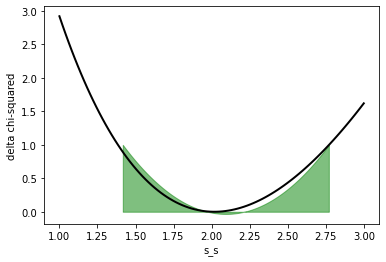

Best fit value of s_s = 2.01 +/- 0.76


In [36]:
s_s_ar = np.linspace(1.0, 3.0, 100) # array of s_s values we will investigate

chi2_ar = np.empty( len(s_s_ar) ) # empty array of that will hold the chi2 values we will calculate

minChi2 = 1000000
bestFit_s_s = 0.0 #starting values for min chi2 and best value of s_s

for s_s in range(0, len(s_s_ar)): #looping over out s_s values 
    pred = (s_s_ar[s_s]*H_125) + (H_bkg) # generating a prediction according to this s_s
    chi2 = calcChiSq(H_data, pred)[0] # calculating chi2
    chi2_ar[s_s] = chi2 # adding chi2 value to chi2 array 
    if(chi2 < minChi2): # check if this is the lowest chi2 we have seen so far
         minChi2 = chi2 # update lowest chi2 value seen 
         bestFit_s_s = s_s_ar[s_s] # update value for best fit s_s

deltaChi2_ar = chi2_ar - minChi2 # make array of delta chi2 values

#we expect the chi2 vs. mZ curve to be quadratic, so let's fit that function to it.
z = np.polyfit(s_s_ar, deltaChi2_ar, 2) #"2" for a second-order polynomial
p = np.poly1d(z)

# we can display the estimated uncertianty on mZ via critical values of the delta chi-squared curve
y0 = 1.0
crit = (p - y0).roots # roots of the polynominal -1, i.e., the mz values where p = 1 

#shading in the confience interval band 
px=np.arange(crit[1],crit[0],0.001)
        
fig, ax = plt.subplots()
ax.plot(s_s_ar, deltaChi2_ar, 'k', linewidth=2)
ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")

plt.xlabel("s_s")
plt.ylabel("delta chi-squared")
plt.show()

print("Best fit value of s_s = " + str(round(bestFit_s_s, 3)) + " +/- " + str(round(np.abs(crit[0] - bestFit_s_s),2 )) )

# Exercise 2
  Discuss the results of the fitting of s_s. Is the fitted model now a successful mode for the data? How can you quantify this?

# Fitting s_b
  Alternatively, we can make the crude assumption that the only thing wrong with our model is that the predicted total number of events from the *backgrounds* is wrong by some single multiplicative factor which we will call s_b.
 We can investigate then how the agreement between the model and the data could be improve by applying various values of s_s and observing the change in the chi-squared. 

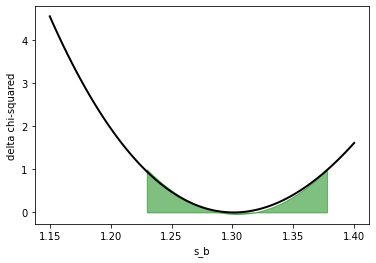

Best fit value of s_b = 1.302 +/- 0.08


In [37]:
s_b_ar = np.linspace(1.15, 1.4, 100)

chi2_ar = np.empty( len(s_b_ar) )

minChi2 = 1000000
bestFit_s_b = 0.0

for s_b in range(0, len(s_b_ar)):
    pred = (H_125) + (s_b_ar[s_b]*H_bkg)
    chi2 = calcChiSq(H_data, pred)[0]
    chi2_ar[s_b] = chi2
    if(chi2 < minChi2):
        minChi2 = chi2
        bestFit_s_b = s_b_ar[s_b]
        
deltaChi2_ar = chi2_ar - minChi2

z = np.polyfit(s_b_ar, deltaChi2_ar, 2)
p = np.poly1d(z)

y0 = 1.0 # this is the value of the delta chi-squared function that defines the 68% CI for a one parameter fit.
         # we'll invetigate if this parmaeter makes sense in the final exercise.
crit = (p - y0).roots 

px=np.arange(crit[1],crit[0],0.001)
        
fig, ax = plt.subplots()
ax.plot(s_b_ar, deltaChi2_ar, 'k', linewidth=2)
ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")
plt.xlabel("s_b")
plt.ylabel("delta chi-squared")
plt.show()

print("Best fit value of s_b = " + str(round(bestFit_s_b, 3)) + " +/- " + str(round(np.abs(crit[0] - bestFit_s_b),2 )) )

# Exercise 3
Discuss the results of the fitting of s_b. Is the fitted model now a successful mode for the data? Is it better than the previous s_s model? How can you quantify this?

# Fitting s_s and s_b
More realistically, we can assume that the the predicted total numbers of events from both the Higgs signal AND the backgrounds are wrong by some two seperate multiplicative factors. We can investigate then how the agreement between the model and the data could be improve by applying various values of (s_s, s_b) and observing the change in the chi-squared. We now need to plot the delta chi-squared as a 2-D function of (s_s, s_b) as it depends on both parmaters.

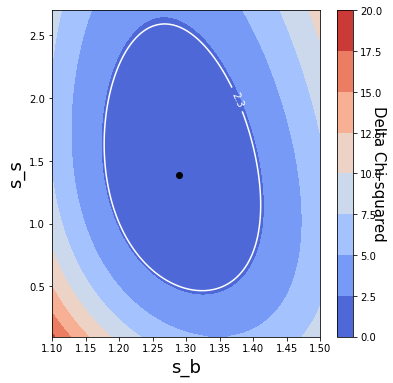

best-fit s_s = 1.386868686868687
best-fit s_b = 1.2898989898989899


In [38]:
s_s_ar = np.linspace(0.1, 2.7, 100)
s_b_ar = np.linspace(1.1, 1.5, 100)

chi2_ar = np.empty( (len(s_s_ar), len(s_b_ar) ))

bestFit_s_s = 0.0
bestFit_s_b = 0.0

minChi2 = 1000000

for s_s in range(0, len(s_s_ar)):
    for s_b in range(0, len(s_b_ar)):
        pred = (s_s_ar[s_s]*H_125) + (s_b_ar[s_b]*H_bkg)
        chi2 = calcChiSq(H_data, pred)[0]
        chi2_ar[s_s, s_b] = chi2 
        if(chi2 < minChi2):
            minChi2 = chi2
            bestFit_s_s = s_s_ar[s_s]
            bestFit_s_b = s_b_ar[s_b]

deltaChi2_ar = chi2_ar - minChi2

levels = [2.3] # this is the value of the delta chi-squared function that defines the 68% CI for a two parameter fit.
         # we'll invetigate if this parmaeter makes sense in the final exercise.
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cfset = plt.contourf(s_b_ar, s_s_ar, deltaChi2_ar,  cmap='coolwarm')
cset = plt.contour(s_b_ar, s_s_ar, deltaChi2_ar, levels=levels, colors=['white'])

bf_point = plt.scatter(bestFit_s_b, bestFit_s_s, color='black')


cbar = plt.colorbar(cfset)
cbar.set_label('Delta Chi-squared', fontsize=15, rotation=270)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('s_b',fontsize=18)
ax.set_ylabel('s_s',fontsize=18)
plt.show()

#extract 2D result
print("best-fit s_s = " + str(bestFit_s_s))
print("best-fit s_b = " + str(bestFit_s_b))

# Exercise 4
Discuss the results of the simulatenous fit of s_s and s_b. How do the results of the three fitting approaches compare? If we interpret the Confidence Intervals on s_s and s_b as uncertainties on measurements of these parameters, then how do the uncertainties compare? Have we measured one parameter better than the other? If so, why? Does it make sense given the histograms we used to perform the fit of these parameters? How do the best-fit vales of the s_s and s_b comapre to the values when we fit one parameter at a time? Discuss what can be learned from the shape of the contours of the 2-D delta-chi-squared function.

Here's a 3D version of the 2-D contour Confidence Interval plot we made earlier, for no reason other than it looks cool and making cool plots is one of the main reasons data analysis is fun!

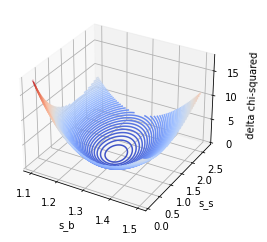

In [39]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(s_b_ar, s_s_ar, deltaChi2_ar, 80, cmap='coolwarm')
ax.set_xlabel('s_b')
ax.set_ylabel('s_s')
ax.set_zlabel('delta chi-squared')
plt.show()

Now we have estimates of the 'best-fit' values of s_s and s_b. Let's apply these factors to the predictions for signal and background and see how the updated predctions compare to data.

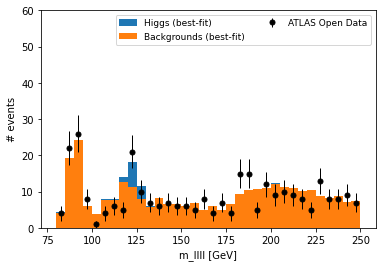

In [40]:
f = plt.figure()

H_125_bf = bestFit_s_s*H_125
H_bkg_bf = bestFit_s_b*H_bkg

hep.histplot([H_bkg_bf, H_125_bf], bins=bins_ar, stack=True, label=["Backgrounds (best-fit)", "Higgs (best-fit)"], histtype='fill')
hep.histplot([H_data], bins=bins_ar, stack=False, yerr=True, histtype="errorbar", color="black",label="ATLAS Open Data")
plt.legend(loc=1, ncol=2, fontsize=9)
plt.xlabel("m_llll [GeV]")
plt.ylabel("# events")
plt.ylim([0.0, 60])
plt.show()

The data and our best-fit predictions agree very well... right?.......right??

# Goodness of fit
We see that our fit succeeded it produced predictions for our signal and background that seem to agree much more closely with data than the original predictions. However, are we sure that our fitted model is a 'good' model for the data? We could as the question: "If this is the correct model, then how probable is our observed data?". This is answered by working our the p-value of our observed data acording to our fitted model. 

In the cell below, we take out fitted model and assume each bin is distrubuted as a gaussian with mean equal to the prediction in the bin and standard deviation equal to the square root of the mean. We generate N toy from the this fitted model and calculate the chi-squared for each toy with respect to the fitted model.

Overlaying the chi-squared value of our ATLAS data with respect to our model "If this is the correct model, then how probable is our observed data?". This is answered by working our the p-value of our observed data acording to our fitted model.

chi2 value of ATLAS Open data is = 33.24431270183961


<Figure size 432x288 with 0 Axes>

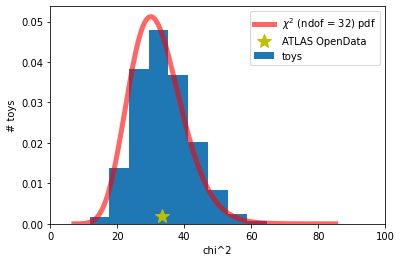

In [41]:
# generate the chi-2 distribution of N toy experiments based on the fitted model 
# assume a gaussian-distributed bin height with mean = model pred. and sigma equal root model pred
# what then is the p-value of the data with respect to the distribution?
    
#function to generate a toy histogram given the mean for each bin and assuming the data is
# gaussian-distrubtu
def generate_toy(means): 
        toy = np.empty(len(means))
        for i in range(0, len(means)):
            toy_bin = np.random.normal(means[i], np.sqrt(means[i]), 1)
            toy[i] = toy_bin
        #print("toy = " + str(toy))
        return toy

ntoys = 10000 # start with a small number, increase when you undertsand your results

means = H_bkg_bf + H_125_bf # take the results of the fit as the means of the fitted model

#print("means" + str(means))

chi2_toys = np.empty(ntoys)

for t in range(0, ntoys):
    toy = generate_toy(means) 
    chi2_toys[t] = calcChiSq(toy, means)[0]
    #print("chi2 " + str(chi2_toys[t]))
    
plt.figure()
fig, ax1 = plt.subplots()

#plot distribtion of chi-squared values from toys
bins_ar = np.linspace(0.0, 200, num=(nBins+1))
chi2Hist, chi2bins = np.histogram(chi2_toys, bins=bins_ar, density=True)                        
hep.histplot([chi2Hist], bins=chi2bins, histtype='fill', label="toys")

#plot expected distrutuon of chi-squared values from theory - chi-squared distribtuions with ndof = nbins -2
df = nBins - 2
x = np.linspace(stats.chi2.ppf(0.000001, df), stats.chi2.ppf(0.999999, df), 200)
label = '$\chi^{2}$ (ndof = ' + str(df) + ') pdf'
ax1.plot(x, stats.chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=label)

# overlay the chi2 squared value from the ATLAS OpenData
chi2_data = calcChiSq(H_data, means)[0]
plt.plot(chi2_data,0.002 , 'y*', ms=14, label='ATLAS OpenData')
plt.legend()
plt.xlabel("chi^2")
plt.ylabel("# toys")
plt.xlim(0,100)

print("chi2 value of ATLAS Open data is = " + str(chi2_data))

# Exercise 5 - Goodness of fit and p-value
Calculate the p-value of the ATLAS data with respect to the chi-squared distribution shown above. Comment if this value indicates if the fitted model is a good model for the ATLAS data or not. Repeat the procedure to calculate the p-value of the data with respect to the model **before** any fitting occured. How do the two p-values compare? What do you conclude about the fitted model? 


In [488]:
# your code goes here

#  Exercise 6 - How do we know the critical value for a Confidence Interval?
Earlier we used critical value of 2.3 of the delta chi-squared function to define the 68% Confidence Interval on our fit parameters. This value of 2.3 is based on the propertires of the Gaussian distribution. In this exercise we aim to check that this value of 2.3 indeed gives us the correct 68 % CL. Recall the definition of a X % CL: *an interval constructed such that if we constructed this interval in the same way for a large number of repeated experiments, it would contain the true value of the parameter in X % of those experiments*.

Use random numbers to work out the critical value of the delta chi-squared corresponding to the boundaries of the 68 % Confidence Interval for the fit performed above. Some hints are given towards the steps needed in the cell below. The steps are not neccessarily in the correct order, they rather they repreent the crucial pieces of information you need to build a solution.

N.B. your setup will likely not initialy give you exaclty the correct critical values with respect to the theoretical expectation? What needs to be done such that the exact critical values can be determined?

In [493]:
# suggested steps

    # generate N toys

        # for each toy, run 2-parameter fit and estimate CL based on critical value d
        # (note that you will fit the toy to the 'true' distributions, not real data)

        # check if true value is within the contour of the delta chiquared function defined by d

    # calculate fraction of toys (f) in which the CL estimation for critical value
    # contains true values of s_s and s_b

    # if you can check the fraction of toys with CI containing the true value 
    # or a given d, you just need to repeat this  for a range of d values.
    # this will take some time, so start with a small number of toys and a few 
    # d values, when you understand your results you can increse both.

    # plot f as a function of d

    # read form this plot the critical value that gives you the 68% CI.
    
# Best of luck!